In [1]:
import matplotlib.pyplot as plt
%matplotlib widget

In [2]:
import cv2
import numpy as np
import scipy.spatial.transform as transform
from math import radians

In [3]:
SIM_MODEL = 'sim' # ARTEMIS sim (paper missions)
FM1_MODEL = 'fm1' # flight rover
EM4_MODEL = 'em4' # test rover
DEBUG_MODEL = 'dbg' # just for debugging
CAMERA_MODEL = DEBUG_MODEL #SIM_MODEL

In [4]:
image_width, image_height = 2592, 1944

In [5]:
# Choose the shape of the Top-Down Map (somewhat arbitrary):
map_width_mm = 120*10*2 # 120cm to either side
map_depth_mm = 420*10   # 420cm away from the rover (things are very squished beyond that)

In [6]:
# Sensor center offsets (x0 and y0)
sensor_width_cm, sensor_height_cm = {
    FM1_MODEL: (0.570, 0.428),
    EM4_MODEL: (0.570, 0.428),
    SIM_MODEL: (0.4699*2592/1944, 0.4699), # (0.66738, 0.4699),
    DEBUG_MODEL: (0.4699*2592/1944, 0.4699)
}[CAMERA_MODEL]

# Intrinsic Parameters:
# Focal length(s):
fx_cm, fy_cm = 0.28, 0.28

# Principle Point Offset:
x0, y0 = 0,0 # sensor_height_cm/2, sensor_width_cm/2

# camera intrinsic matrix K
skew = 0
K = np.array([[ fx_cm,  skew,   x0],
              [ 0,      fy_cm,  y0],
              [ 0,      0,      1]])
K = np.hstack((K, np.zeros((3,1))))

# Extrinsic Parameters:
# Translation:
# X is alongtrack, Y is crosstrack
a_cm = 12.40  # Alongtrack Offset in cm
b_cm = 15.82  # Height in cm
t = np.array([a_cm, 0, b_cm]).reshape((3,1))

# Rotation:
theta_deg = { # downwards tilt angle in degrees (use 20° for simulation)
    FM1_MODEL: 25,
    EM4_MODEL: 25,
    SIM_MODEL: 20,
    DEBUG_MODEL: 20
}[CAMERA_MODEL]
rotate_about = 'y'  # crosstrack
r_unit_vec = {'x': np.array([1, 0, 0]), 'y': np.array([0, 1, 0]), 'z': np.array([0, 0, 1])}[rotate_about]
rotation = transform.Rotation.from_rotvec(theta_deg * r_unit_vec, degrees=True)
R = rotation.as_matrix()

# Build Homography Matrix:
T = np.hstack((R, t))
T = np.vstack((T, np.array([[0,0,0,1]])))
H4 = K @ T

# Planar-ize Homography (we don't care about Z):
H = H4[:, (0,1,3)]
# ^ equiv. to:
# H = K[:3, :3] @ T[:3, (0,1,3)]

# # Restrict to 8DOF by setting H_33 to 1:
# H[2,2] = 1
# ^^ should this be a set or a normalization?

H_inv = np.linalg.inv(H)
H_inv

H, H_inv

(array([[ 0.26311393,  0.        ,  3.472     ],
        [ 0.        ,  0.28      ,  0.        ],
        [-0.34202014,  0.        , 15.82      ]]),
 array([[ 2.95703346, -0.        , -0.64897726],
        [ 0.        ,  3.57142857,  0.        ],
        [ 0.06392952,  0.        ,  0.04918058]]))

In [7]:
from typing import Dict, Tuple, TypeAlias
PX_COORD: TypeAlias = Tuple[float, float]  # pixel space
UV_COORD: TypeAlias = Tuple[float, float]  # sensor space
XY_COORD: TypeAlias = Tuple[float, float]  # world space, ground plane

In [8]:
from collections import OrderedDict
from typing import Tuple, TypeAlias
PX_COORD: TypeAlias = Tuple[float, float]  # pixel space (row, col)
UV_COORD: TypeAlias = Tuple[float, float]  # sensor space
XY_COORD: TypeAlias = Tuple[float, float]  # world space, ground plane

def px2uv(px_coord: PX_COORD) -> UV_COORD:
    px_row, px_col = px_coord
    # Convert to sensor coordinates. Rel. to center of sensor,
    # with U+=X+ being up and V+=Y+ being left

    # since X+=U+ increases as we move AWAY from the camera, as we increase the row number, we should be decreasing u, crossing 0 in the middle:
    u = -(px_row * sensor_height_cm/image_height) + sensor_height_cm/2
    # since Y+=V+ increases as we move LEFT, as we increase the column number, we should be decreasing v, crossing 0 in the middle:
    v = -(px_col * sensor_width_cm/image_width) + sensor_width_cm/2

    return (u,v)

# Convert some known pairs (measured from cartesian image grid):
ground_truth: OrderedDict[PX_COORD, XY_COORD] = OrderedDict([
    # X is alongtrack (fwd), Y is crosstrack (left)
    # (row,col), (X,Y)
    ((1411, image_width/2), (30, 0)),
    ((940, image_width/2),  (60, 0)),
    ((809, image_width/2),  (90, 0)),
    ((749, image_width/2),  (120, 0)),
    ((712, image_width/2),  (150, 0)),
    #
    ((940, 688),            (60, 30)),
    ((809, 907),            (90, 30)),
    ((809, 492),            (90, 60)),
    #
    ((940, 1987),           (60, -30)),
    ((809, 1739),           (90, -30)),
    ((809, 2156),           (90, -60))
    # # 12 points wasn't enough for RANSAC to consistently yield good results.
    # # ... upping to every grid point w/in X<=150cm (easily visible):
    # ((940, ),           (60, 60)),
    # ((940, ),           (60, -60)),
])

In [9]:
src_pts = np.float32([ [p[0],p[1]] for p in ground_truth.keys() ])
dst_pts = np.float32([ [p[0],p[1]] for p in ground_truth.values() ])

In [10]:
## 16720 Homography Code
import warnings
from types import SimpleNamespace
opts = SimpleNamespace()
opts.max_iters: int = 500 # the number of iterations to run RANSAC for
opts.inlier_tol: float = 2.0 # 'the tolerance value for considering a point to be an inlier
def computeH(x1, x2):
    """
    Compute the homography between two sets of points.

    Q2.2.1
    """
    Npts = x1.shape[0]
    Npts2 = x2.shape[0]
    assert Npts==Npts2, "Number of points in each list must be equal"
    
    A = np.zeros((Npts*2,9))
    
    for i in range(Npts):
        A[i*2:(i+1)*2, :] = np.array([
            [-x2[i,0], -x2[i,1], -1, 0, 0, 0, x1[i,0]*x2[i,0], x1[i,0]*x2[i,1], x1[i,0]],
            [0, 0, 0, -x2[i,0], -x2[i,1], -1, x1[i,1]*x2[i,0], x1[i,1]*x2[i,1], x1[i,1]],
        ])
        
        
    """
    SVD Approach (works fine, just slower than eig. Keeping in case of issue with eig.)
    _, s, Vh = np.linalg.svd(A, full_matrices=True)
    if s.shape[0] > 8 and abs(s[8]) > 1e-6:
        warnings.warn("Min singular value should be approximately zero.")
    V = Vh.T
    H2to1 = V[:,8] # Solution is eigenvector for smallest eigenvalue of A.T@A (last col of V)
    """
    D,V = np.linalg.eig(A.T@A)
    D = np.absolute(D) # only care about distance of e-values from 0
    i_min = np.argmin(D)
    if D[i_min] > 1e-3:
        warnings.warn("Min singular value should be approximately zero; it was {}.".format(D[i_min]))
    H2to1 = V[:,i_min]
    
    return H2to1.reshape((3,3))

def point_mean(x):
    """Compute mean of columns of given matrix x (faster than np.mean)."""
    Npts = x.shape[0]
    return np.sum(x[:, 0])/Npts, np.sum(x[:, 1])/Npts

def computeH_norm(x1, x2):
    """
    Compute the centroid of the points.
    
    Q2.2.2
    """
    #Shift the origin of the points to the centroid
    mean1 = point_mean(x1) # mean for each column (xvalues,yvalues) in x1
    mean2 = point_mean(x2) # mean for each column (xvalues,yvalues) in x2
    x1_centered = x1 - mean1
    x2_centered = x2 - mean2

	#Normalize the points so that the largest distance from the origin is equal to sqrt(2)
    max1 = np.max(np.absolute(x1_centered), axis=0)
    max2 = np.max(np.absolute(x2_centered), axis=0)
    if np.count_nonzero(max1==0) == 0:
        scale1 = 1.0 / max1 # scaling for each column (xvalues,yvalues) in x1
    else:
        warnings.warn("Zeros in maximum value for a column in x1. Ignoring scaling for that point collection.")
        scale1 = np.ones(max1.shape) # can't scale so don't. this likely won't generate the solution given this anomaly so this is fine.
    if np.count_nonzero(max2==0) == 0:
        scale2 = 1.0 / max2 # scaling for each column (xvalues,yvalues) in x2
    else:
        warnings.warn("Zeros in maximum value for a column in x2. Ignoring scaling for that point collection")
        scale2 = np.ones(max2.shape) # can't scale so don't. this likely won't generate the solution given this anomaly so this is fine.
    x1_normalized = x1_centered * scale1
    x2_normalized = x2_centered * scale2

	#Similarity transform 1
    T1 = np.array([
        [scale1[0], 0, -mean1[0]*scale1[0]],
        [0, scale1[1], -mean1[1]*scale1[1]],
        [0, 0, 1]
    ])

	#Similarity transform 2
    T2 = np.array([
        [scale2[0], 0, -mean2[0]*scale2[0]],
        [0, scale2[1], -mean2[1]*scale2[1]],
        [0, 0, 1]
    ])

	#Compute homography
    H2to1_norm = computeH(x1_normalized, x2_normalized)

	#Denormalization
    H2to1 = np.linalg.inv(T1) @ H2to1_norm @ T2

    return H2to1

def computeH_ransac(locs1, locs2, opts):
    """
    Compute the best fitting homography given a list of matching points.
    
    Q2.2.3
    """
    max_iters = opts.max_iters  # the number of iterations to run RANSAC for
    inlier_tol = opts.inlier_tol # the tolerance value for considering a point to be an inlier

    # Copy and swap columns (from (y,x) to (x,y)) per Piazza
    pts1 = np.copy(locs1)
    pts1[:,[1,0]] = pts1[:,[0,1]]
    pts2 = np.copy(locs2)
    pts2[:,[1,0]] = pts2[:,[0,1]]

    Npts = pts1.shape[0]
    Npts2 = pts2.shape[0]
    assert Npts == Npts2, "Both locs should contain same number of points."

    # Make homogeneous ahead of time for use in RANSAC inlier testing:
    pts_h1 = pts1.T
    pts_h1 = np.append(pts_h1, np.ones((1,Npts)), axis=0)
    pts_h2 = pts2.T
    pts_h2 = np.append(pts_h2, np.ones((1,Npts)), axis=0)

    # Count inliers in model given by homography H:
    def count_inliers(H):
        estimate = H@pts_h2
        # Rescale third element to rehomogenize estimate (account for "up to scale" equivalence):
        if np.count_nonzero(estimate[2,:]) == estimate.shape[1]:
            estimate = estimate / estimate[2,:]
        inliers = np.linalg.norm(pts_h1 - estimate, axis=0) < inlier_tol # True if inlier
        num_inliers = np.count_nonzero(inliers)
        return num_inliers, inliers

    count = 1
    bestH2to1 = None
    best_inliers = None # Boolean vector with True for inliers during best homography fit
    best_inlier_count = -1
    while count < max_iters:
        # Select randomly the minimum number of points to fix model (8 points = 4 correspondences):
        sample_idx = np.random.choice(Npts, 4)
        sample1 = pts1[sample_idx,:]
        sample2 = pts2[sample_idx,:]
        
        # Solve for model (H):
        H2to1 = computeH_norm(sample1, sample2)
        
        # Count inliers:
        num_inliers, inliers = count_inliers(H2to1)
        
        # If best homography, save the model and the inliers (to try to build a better model later):
        if num_inliers > best_inlier_count:
            bestH2to1 = H2to1
            best_inliers = inliers
            best_inlier_count = num_inliers
        
        # If all points are (somehow) inliers, woohoo! Terminate early.
        if num_inliers == Npts:
            #terminate early
            break

        count = count + 1
        
    # Rebuild model using all inliers from best fit:
    H2to1 = computeH_norm(pts1[best_inliers,:], pts2[best_inliers,:])
    num_inliers, inliers = count_inliers(H2to1)
    # Make sure it's actually an improvement; if so, keep:
    if num_inliers > best_inlier_count:
        bestH2to1 = H2to1
        best_inliers = inliers

    inliers = (best_inliers*1) # convert from Bool to Int vector (per spec)
    return bestH2to1, inliers

def compositeH(H2to1, template, img):
    """
    Create a composite image after warping the template image on top of the image using the homography
    """
    #Note that the homography we compute is from the image to the template;
    #x_template = H2to1*x_photo
    #For warping the template to the image, we need to invert it.
    H1to2 = np.linalg.inv(H2to1)
	
    #Create mask of same size as template
    mask = np.ones(template.shape)

    #Warp mask by appropriate homography
    warped_mask = cv2.warpPerspective(mask, H1to2, (img.shape[1],img.shape[0]))
    #Warp template by appropriate homography
    warped_template = cv2.warpPerspective(template, H1to2, (img.shape[1],img.shape[0]))
    
    #Use mask to combine the warped template and the image
    composite_img = img * (np.logical_not(warped_mask)) + warped_template
    
    return composite_img

In [11]:
# Scale Ground Truth from [cm] to [mm] (for better integer resolution):
dst_pts *= 10
# Shift Ground Truth along crosstrack axis so no position in the map size are negative:
dst_pts[:, 1] += map_width_mm / 2

# Solve a Homography:
bestH2to1, _ = computeH_ransac(src_pts, dst_pts, opts)
bestH1to2 = np.linalg.inv(bestH2to1)
bestH2to1, bestH1to2

/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_99469/844935849.py:66: UserWarning: Zeros in maximum value for a column in x1. Ignoring scaling for that point collection.
  warnings.warn("Zeros in maximum value for a column in x1. Ignoring scaling for that point collection.")
/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_99469/844935849.py:71: UserWarning: Zeros in maximum value for a column in x2. Ignoring scaling for that point collection
  warnings.warn("Zeros in maximum value for a column in x2. Ignoring scaling for that point collection")


(array([[-1.28070004e+00,  1.33228505e+00,  1.44787885e+03],
        [-7.37531353e-03,  5.91094545e-01,  1.69818327e+02],
        [-9.11658038e-06,  1.02799772e-03, -5.77029962e-02]]),
 array([[-7.98159024e-01,  5.98690850e+00, -2.40803415e+03],
        [-7.54913072e-03,  3.33138479e-01,  7.90995192e+02],
        [-8.38792302e-06,  4.98909042e-03, -2.85783613e+00]]))

In [12]:
bestH2to1 / bestH2to1[2,2], bestH1to2 / bestH1to2[2,2]

(array([[ 2.21946887e+01, -2.30886633e+01, -2.50919181e+04],
        [ 1.27815088e-01, -1.02437410e+01, -2.94297244e+03],
        [ 1.57991456e-04, -1.78153266e-02,  1.00000000e+00]]),
 array([[ 2.79287891e-01, -2.09490966e+00,  8.42607500e+02],
        [ 2.64155479e-03, -1.16570183e-01, -2.76781158e+02],
        [ 2.93506088e-06, -1.74575805e-03,  1.00000000e+00]]))

In [13]:
# Doesn't work quite right for some reason...
# bestH2to1, _ = cv2.findHomography(
#     src_pts[:,[1,0]], dst_pts[:,[1,0]],  # Need to swap X and Y to fit expectations
#     # LMEDS will work w/out us manually specifying an inlier tolerance (guesswork)
#     # but only if >50% of the points are inliers (which they should be given
#     # that we manually selected them)...
#     # If this is not the case, use RANSAC or RHO (an improvement on RANSAC)
#     method=cv2.LMEDS, # cv2.RANSAC
#     ransacReprojThreshold=2.0  # not needed if not using RANSAC or RHO
# )
# bestH1to2 = np.linalg.inv(bestH2to1)
# bestH2to1, bestH1to2

In [14]:
def px2ground(px_coord: PX_COORD, H) -> XY_COORD:
    # Converts pixel coordinates to XY coordinates on the ground plane in world coordinates
    # Convert Pixel Coordinates to UV coordinates on the sensor frame:
    uv_cm = px2uv(px_coord)
    # Build Homogeneous vector:
    u_cm = np.array([*uv_cm, 1]).reshape((3,1))
    # Apply Homography:
    x: np.ndarray = H @ u_cm
    # Normalize homogeneous coordinates:
    x_cm: np.ndarray = x / x[-1]
    return (x_cm[0,0], x_cm[1,0])

In [15]:
# Run some tests:
print("Pixel (r,c)  \tCalc. XY \t\t  Real XY\tError")
for px_coord, xy_coord in ground_truth.items():
    px, py = px_coord
    xy_est = bestH1to2 @ np.array([px_coord[1], px_coord[0],1]).reshape((3,1))
    # Normalize (and de-homogenize):
    xy_est = xy_est[[1,0], :] / xy_est[-1]
    # Shift est back to middle (restore negative values):
    xy_est[1] -= map_width_mm/2
    # Convert Est. to cm:
    xy_est /= 10

    # Compute Error and Display Results:
    xy_truth = np.array([*xy_coord]).reshape((2,1))
    diff = xy_truth-xy_est
    rmse = np.linalg.norm(diff) / np.sqrt(diff.size)
    p_error = rmse / np.linalg.norm(xy_truth)
    print(f"({int(px):4d},{int(py):4d}) -> ({xy_est[0,0]:.1f}, {xy_est[1,0]:.1f})\t v.\t ({xy_truth[0,0]:.1f}, {xy_truth[1,0]:.1f}) \t{p_error*100:.1f}%")

Pixel (r,c)  	Calc. XY 		  Real XY	Error
(1411,1296) -> (30.0, -0.0)	 v.	 (30.0, 0.0) 	0.0%
( 940,1296) -> (60.1, -0.0)	 v.	 (60.0, 0.0) 	0.1%
( 809,1296) -> (90.0, -0.0)	 v.	 (90.0, 0.0) 	0.0%
( 749,1296) -> (118.7, -0.0)	 v.	 (120.0, 0.0) 	0.7%
( 712,1296) -> (149.0, 0.0)	 v.	 (150.0, 0.0) 	0.5%
( 940, 688) -> (60.2, 26.2)	 v.	 (60.0, 30.0) 	4.0%
( 809, 907) -> (90.0, 26.2)	 v.	 (90.0, 30.0) 	2.8%
( 809, 492) -> (90.0, 54.0)	 v.	 (90.0, 60.0) 	3.9%
( 940,1987) -> (60.0, -30.0)	 v.	 (60.0, -30.0) 	0.0%
( 809,1739) -> (90.0, -30.0)	 v.	 (90.0, -30.0) 	0.0%
( 809,2156) -> (90.0, -58.4)	 v.	 (90.0, -60.0) 	1.0%


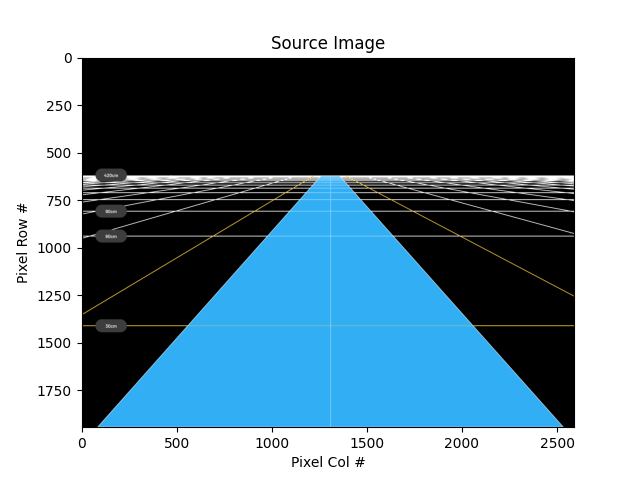

In [16]:
im_src = cv2.imread('/Users/connorcolombo/Documents/PKBACK/GitHub/CubeRoverPackage_frontend/CubeRoverPackage/Apps/FrontendSoftware/src/assets/cartesian_grid.png')
im_src = cv2.resize(im_src, (image_width, image_height))
plt.figure()
plt.imshow(cv2.cvtColor(im_src, cv2.COLOR_BGR2RGB))
plt.title("Source Image")
plt.xlabel("Pixel Col #")
plt.ylabel("Pixel Row #")
plt.show(block=False)

/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_99469/793652675.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([str(l) for l in labels])


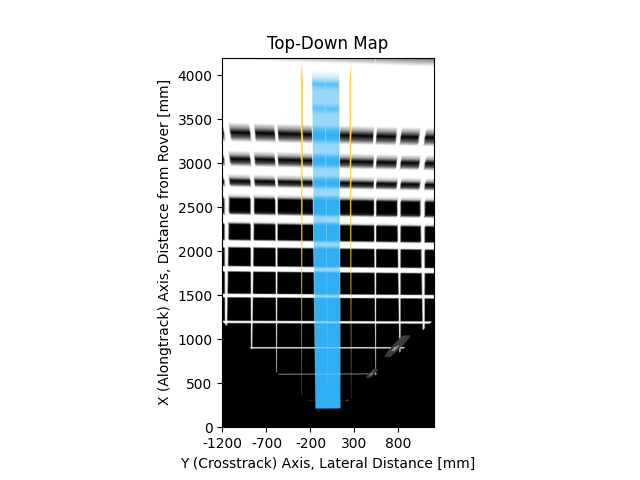

In [17]:
warped = cv2.warpPerspective(im_src, bestH1to2, (map_width_mm, map_depth_mm))
warped = np.fliplr(warped)
plt.figure()
plt.imshow(cv2.cvtColor(warped, cv2.COLOR_BGR2RGB))
plt.gca().invert_yaxis()
plt.title("Top-Down Map")
plt.xlabel("Y (Crosstrack) Axis, Lateral Distance [mm]")
plt.ylabel("X (Alongtrack) Axis, Distance from Rover [mm]")

# Adjust X-Axis Tick labels so they represent reality
# (we had to shift everything by `map_width_mm` so no top-down columns would be
# negative and now we have to shift everything back):
axs = plt.gca()
labels = [item.get_text() for item in axs.get_xticklabels()]
# Replace unicode ticks '-' with ASCII ticks (so they can be parsed by int):
labels = [l.replace(u'\u2212', '-') for l in labels]
# Convert Labels to int & shift:
labels = [int(l)-map_width_mm//2 for l in labels]
# Convert back to text and apply:
axs.set_xticklabels([str(l) for l in labels])

plt.show(block=False)

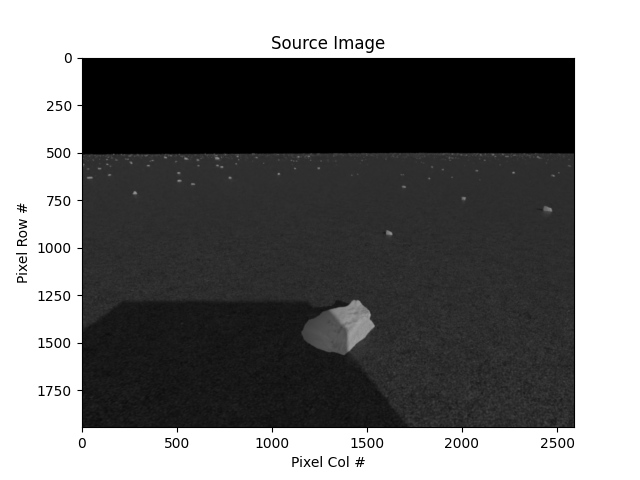

/var/folders/44/s4c635957kj582ykvhndm9w00000gn/T/ipykernel_99469/3308550219.py:29: UserWarning: FixedFormatter should only be used together with FixedLocator
  axs.set_xticklabels([str(l) for l in labels])


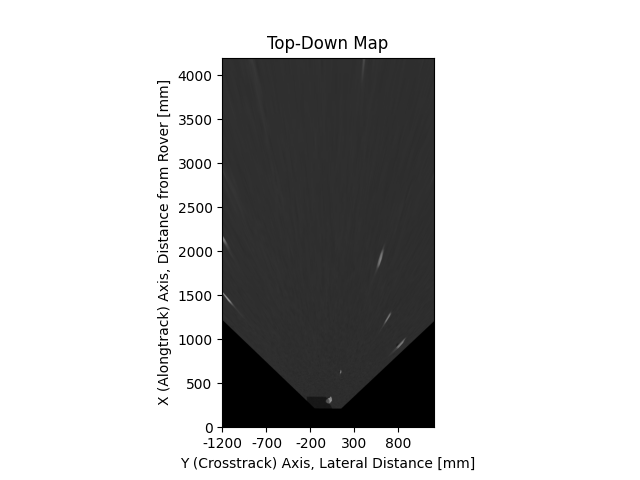

In [19]:
im_src2 = cv2.imread('/Users/connorcolombo/Documents/PKBACK/GitHub/CubeRoverPackage_frontend/CubeRoverPackage/Apps/FrontendSoftware/public/images/Rocco.jpg')
im_src2 = cv2.resize(im_src2, (image_width, image_height))
plt.figure()
plt.imshow(cv2.cvtColor(im_src2, cv2.COLOR_BGR2RGB))
plt.title("Source Image")
plt.xlabel("Pixel Col #")
plt.ylabel("Pixel Row #")
plt.show(block=False)

warped2 = cv2.warpPerspective(im_src2, bestH1to2, (map_width_mm, map_depth_mm))
warped2 = np.fliplr(warped2)
plt.figure()
plt.imshow(cv2.cvtColor(warped2, cv2.COLOR_BGR2RGB))
plt.gca().invert_yaxis()
plt.title("Top-Down Map")
plt.xlabel("Y (Crosstrack) Axis, Lateral Distance [mm]")
plt.ylabel("X (Alongtrack) Axis, Distance from Rover [mm]")

# Adjust X-Axis Tick labels so they represent reality
# (we had to shift everything by `map_width_mm` so no top-down columns would be
# negative and now we have to shift everything back):
axs = plt.gca()
labels = [item.get_text() for item in axs.get_xticklabels()]
# Replace unicode ticks '-' with ASCII ticks (so they can be parsed by int):
labels = [l.replace(u'\u2212', '-') for l in labels]
# Convert Labels to int & shift:
labels = [int(l)-map_width_mm//2 for l in labels]
# Convert back to text and apply:
axs.set_xticklabels([str(l) for l in labels])

plt.show(block=False)